In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import shap
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree

In [2]:
x_data, y_data = make_classification(n_samples=8096, n_features=16, n_informative=8)
x_data = np.abs(x_data) + 1e-3

In [3]:
x_data

array([[0.19223162, 1.085198  , 2.645434  , ..., 1.22385433, 0.97006346,
        2.72428311],
       [1.59905237, 0.60418633, 2.36527242, ..., 2.71290756, 0.1465962 ,
        1.57146819],
       [0.93385458, 0.98984971, 1.47340905, ..., 0.00559194, 0.81933935,
        1.84249842],
       ...,
       [0.97457669, 2.30407027, 2.98837115, ..., 1.13521569, 0.8477495 ,
        2.45998001],
       [1.75669743, 4.06966282, 0.78969223, ..., 0.90219803, 1.04708543,
        0.3751937 ],
       [3.89758099, 1.2219962 , 2.44780905, ..., 2.58474857, 0.17376743,
        0.33678358]])

In [4]:
y_data

array([1, 1, 0, ..., 0, 0, 0])

In [5]:
#

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6072, 16), (2024, 16), (6072,), (2024,))

In [8]:
#

In [9]:
model = RandomForestClassifier(max_depth=3, n_estimators=4)

model.fit(x_train, y_train)
print(balanced_accuracy_score(y_test, model.predict(x_test)))

0.5980815179130258


In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

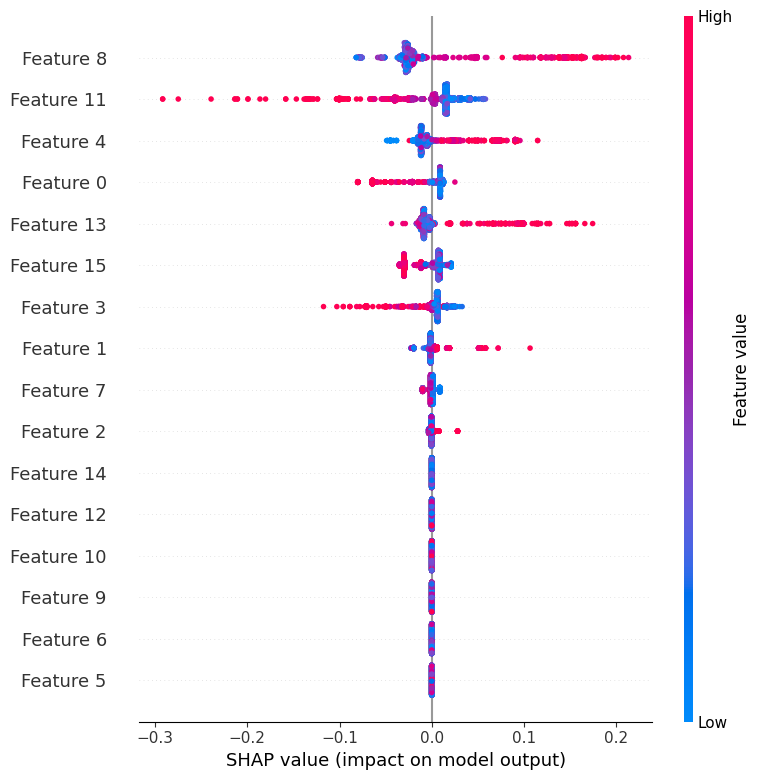

In [11]:
shap.summary_plot(shap_values[1], x_test)

In [12]:
#

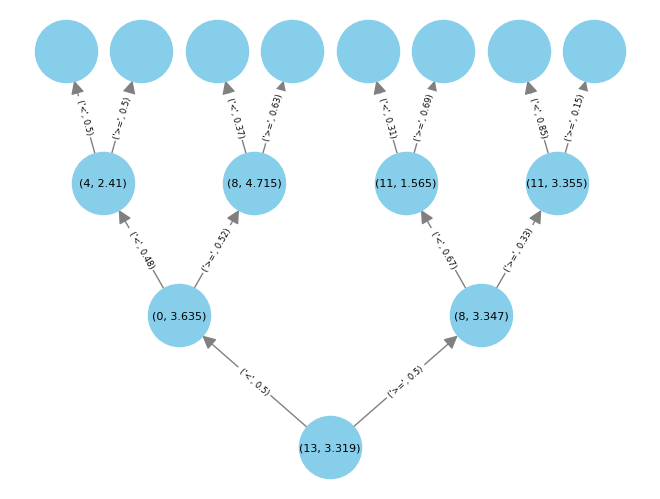

In [28]:
first_tree = model.estimators_[0].tree_
feature_names = list(range(x_train.shape[1]))


def tree_to_networkx(tree, feature_names=None, node=0, graph=None, pos=None, level=0, width=1., vert_gap=0.2, xcenter=0.5):
	if graph is None:
		graph = nx.DiGraph()
	
	if pos is None:
		pos = {node: (xcenter, level * -vert_gap)}
	else:
		pos[node] = (xcenter, level * -vert_gap)
	
	if tree.feature[node] != _tree.TREE_UNDEFINED:
		name = feature_names[tree.feature[node]]
		threshold = tree.threshold[node]
		condition = (name, np.round(threshold, 3))
		graph.add_node(node, label=condition)
		
		left_child = tree.children_left[node]
		right_child = tree.children_right[node]
		
		if left_child != right_child:  # If not a leaf node
			parent_rate = tree.value[node][0, 1] + tree.value[node][0, 0]
			graph, pos = tree_to_networkx(
					tree, feature_names, left_child, graph=graph, pos=pos,
					level=level - 1, width=width / 2., vert_gap=vert_gap, xcenter=xcenter - width / 2.
					)
			graph, pos = tree_to_networkx(
					tree, feature_names, right_child, graph=graph, pos=pos,
					level=level - 1, width=width / 2., vert_gap=vert_gap, xcenter=xcenter + width / 2.
					)
			graph.add_edge(node, left_child, label=('<', np.round(tree.value[node][0, 1] / parent_rate, 2)))
			graph.add_edge(node, right_child, label=('>=', np.round(tree.value[node][0, 0] / parent_rate, 2)))
	
	else:
		# Leaf node
		graph.add_node(node)
	
	return graph, pos


graph = nx.DiGraph()
graph, pos = tree_to_networkx(first_tree, feature_names, graph=graph)

# Draw the graph
labels = nx.get_edge_attributes(graph, 'label')
nx.draw(graph, pos, with_labels=True, labels=nx.get_node_attributes(graph, 'label'), node_size=2000, font_size=8, node_color='skyblue', edge_color='gray', arrowsize=20)
nx.draw_networkx_edge_labels(graph, pos, edge_labels={edge: label for edge, label in labels.items()}, font_size=6)

plt.show()

In [29]:
def generate_paths(graph, min_length=2, max_length=None):
	if max_length is None:
		max_length = len(graph)
	
	all_paths = []
	for root in graph.nodes:
		for leaf in graph.nodes:
			for path in nx.all_simple_paths(graph, root, leaf):
				
				if len(path) <= 1:
					continue
				
				all_paths.append(path)
	
	return all_paths


def print_paths(graph, paths, node_label_attr='label', edge_label_attr='label'):
	for path in paths:
		node_names = [graph.nodes[node].get(node_label_attr, 'unknown') for node in path][: -1]
		edge_names = []
		for i in range(len(path) - 1):
			edge_data = graph.get_edge_data(path[i], path[i + 1])
			if edge_data and edge_label_attr in edge_data:
				edge_label = edge_data[edge_label_attr]
				edge_names.append(edge_label)
		
		result = []
		for node, edge in zip(node_names, edge_names):
			result.append(((node[0], edge[0], node[1]), edge[1]))
		
		print(result)


paths = generate_paths(graph)
print_paths(graph, paths)

[((13, '<', 3.319), 0.5)]
[((13, '<', 3.319), 0.5), ((0, '<', 3.635), 0.48)]
[((13, '<', 3.319), 0.5), ((0, '<', 3.635), 0.48), ((4, '<', 2.41), 0.5)]
[((13, '<', 3.319), 0.5), ((0, '<', 3.635), 0.48), ((4, '>=', 2.41), 0.5)]
[((13, '<', 3.319), 0.5), ((0, '>=', 3.635), 0.52)]
[((13, '<', 3.319), 0.5), ((0, '>=', 3.635), 0.52), ((8, '<', 4.715), 0.37)]
[((13, '<', 3.319), 0.5), ((0, '>=', 3.635), 0.52), ((8, '>=', 4.715), 0.63)]
[((13, '>=', 3.319), 0.5)]
[((13, '>=', 3.319), 0.5), ((8, '<', 3.347), 0.67)]
[((13, '>=', 3.319), 0.5), ((8, '<', 3.347), 0.67), ((11, '<', 1.565), 0.31)]
[((13, '>=', 3.319), 0.5), ((8, '<', 3.347), 0.67), ((11, '>=', 1.565), 0.69)]
[((13, '>=', 3.319), 0.5), ((8, '>=', 3.347), 0.33)]
[((13, '>=', 3.319), 0.5), ((8, '>=', 3.347), 0.33), ((11, '<', 3.355), 0.85)]
[((13, '>=', 3.319), 0.5), ((8, '>=', 3.347), 0.33), ((11, '>=', 3.355), 0.15)]
[((0, '<', 3.635), 0.48)]
[((0, '<', 3.635), 0.48), ((4, '<', 2.41), 0.5)]
[((0, '<', 3.635), 0.48), ((4, '>=', 2.41), 